In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
!pip install -U -q PyDrive 
  
from pydrive.auth import GoogleAuth 
from pydrive.drive import GoogleDrive 
from google.colab import auth 
from oauth2client.client import GoogleCredentials 
  
  
# Authenticate and create the PyDrive client. 
auth.authenticate_user() 
gauth = GoogleAuth() 
gauth.credentials = GoogleCredentials.get_application_default() 
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/file/d/1b7CeQculr6Z3uoiu2_TmkZiWEG5iTuLz/view?usp=sharing'

id = link.split("/")[-2] 
  
downloaded = drive.CreateFile({'id':id})  
downloaded.GetContentFile('train.csv')   
  
df = pd.read_csv('train.csv') 
print(df)



                id  vendor_id  ... store_and_fwd_flag trip_duration
0        id2875421          2  ...                  N           455
1        id2377394          1  ...                  N           663
2        id3858529          2  ...                  N          2124
3        id3504673          2  ...                  N           429
4        id2181028          2  ...                  N           435
...            ...        ...  ...                ...           ...
1458639  id2376096          2  ...                  N           778
1458640  id1049543          1  ...                  N           655
1458641  id2304944          2  ...                  N           764
1458642  id2714485          1  ...                  N           373
1458643  id1209952          1  ...                  N           198

[1458644 rows x 11 columns]


In [3]:
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
def timezone(x):
    if x>=datetime.time(4, 0, 1) and x <=datetime.time(10, 0, 0):
        return 'morning'
    elif x>=datetime.time(10, 0, 1) and x <=datetime.time(16, 0, 0):
        return 'midday'
    elif x>=datetime.time(16, 0, 1) and x <=datetime.time(22, 0, 0):
        return 'evening'
    elif x>=datetime.time(22, 0, 1) or x <=datetime.time(4, 0, 0):
        return 'late night'
    

In [5]:
def newfunct(x):
    for i in range (0,24):
        if x>=datetime.time(i, 0, 1) and x <=datetime.time(i+1, 0, 0):
            return i

In [6]:
from math import radians, cos, sin, asin, sqrt

def haversine(df):
    lat1, lon1, lat2, lon2 = df.pickup_latitude,df.pickup_longitude,df.dropoff_latitude,df.dropoff_longitude 
    R =  6372.8# this is in miles.  For Earth radius in kilometers use 6372.8 km
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))
    return R * c

In [7]:
df.drop(["id","vendor_id","passenger_count","store_and_fwd_flag"],axis=1, inplace= True)

df['pickup_datetime']=pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime']=pd.to_datetime(df['dropoff_datetime'])

df['pickup_timezone']=df['pickup_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )
df['dropoff_timezone']=df['dropoff_datetime'].apply(lambda x :timezone(datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S").time()) )

df['pickup_day']=df['pickup_datetime'].dt.day_name()
df['dropoff_day']=df['dropoff_datetime'].dt.day_name()

df['distance'] = df.apply(lambda x: haversine(x), axis = 1)

df['pickup_month']=df['pickup_datetime'].dt.month
df['dropoff_month']=df['dropoff_datetime'].dt.month

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


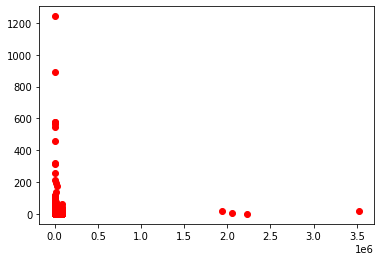

In [8]:
plt.scatter(df.trip_duration,df.distance,color='red')
plt.scatter(np.log2(df['distance']), np.log2(df['trip_duration']), color='red')

In [9]:
df['logdistance']=df['distance']
df['logduration']=df['trip_duration']

df = df[df.logdistance != 0]
df = df[df.logduration != 0]

df['logdistance']=np.log(df['logdistance'])
df['logduration']=np.log(df['logduration'])

df=df[df.logduration<10]

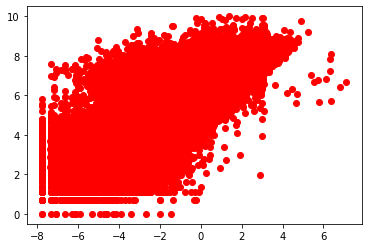

In [10]:
plt.scatter(x=df['logdistance'], y=df['logduration'], color='red')

In [11]:
final_data=df.loc[:,['logduration', 'pickup_day', 'dropoff_day', 'pickup_month','dropoff_month','pickup_timezone','dropoff_timezone','logdistance']]
final_data=pd.get_dummies(final_data,columns=['pickup_day','dropoff_day','pickup_month','dropoff_month','pickup_timezone', 'dropoff_timezone'])

final_data.head()

,logduration,logdistance,pickup_day_Friday,pickup_day_Monday,pickup_day_Saturday,pickup_day_Sunday,pickup_day_Thursday,pickup_day_Tuesday,pickup_day_Wednesday,dropoff_day_Friday,dropoff_day_Monday,dropoff_day_Saturday,dropoff_day_Sunday,dropoff_day_Thursday,dropoff_day_Tuesday,dropoff_day_Wednesday,pickup_month_1,pickup_month_2,pickup_month_3,pickup_month_4,pickup_month_5,pickup_month_6,dropoff_month_1,dropoff_month_2,dropoff_month_3,dropoff_month_4,dropoff_month_5,dropoff_month_6,dropoff_month_7,pickup_timezone_evening,pickup_timezone_late night,pickup_timezone_midday,pickup_timezone_morning,dropoff_timezone_evening,dropoff_timezone_late night,dropoff_timezone_midday,dropoff_timezone_morning
0,6.120297,0.404761,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
1,6.496775,0.591124,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
2,7.661056,1.854249,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,6.061457,0.396033,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0
4,6.075346,0.173049,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0


In [12]:
from google.colab import files
final_data.to_csv ('refined_data.csv', index = False, header=True)
files.download('refined_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>